In [ ]:
import time
import pandas as pd
from pathlib import Path
import json
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
# import matplotlib.pyplot as plt
# from sklearn.metrics import (
#     confusion_matrix,
#     classification_report,
#     roc_auc_score,
#     roc_curve
# )

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

if DEVICE == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
processed_data = Path("../data/processed/cxr")
train = processed_data / "train"
val_dir = processed_data / "val"

artifacts = Path("../artifacts")
artifacts.mkdir(parents=True, exist_ok=True) # save model weights, classes, training config

BATCH_SIZE = 32
WORKERS = 2
EPOCHS = 5
LR = 1e-4 # step size of optimizer

In [4]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), #3
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406],
    #     std =[0.229, 0.224, 0.225]
    # ),
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), #3
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406],
    #     std =[0.229, 0.224, 0.225]
    # ),
])

In [5]:
train_ds = datasets.ImageFolder(train, transform=train_transforms)
val_ds = datasets.ImageFolder(val_dir, transform=val_transforms)

classes = train_ds.classes
(artifacts / "classes.json").write_text(json.dumps(classes, indent=2))

train_loader = DataLoader(
  train_ds, batch_size=BATCH_SIZE, shuffle=True,
  num_workers=WORKERS, pin_memory=(DEVICE=="cuda") 
)

val_loader = DataLoader(
  val_ds, batch_size=BATCH_SIZE, shuffle=False,
  num_workers=WORKERS, pin_memory=(DEVICE=="cuda")
)

print("Classes:", classes)
print("Train:", len(train_ds), "Val:", len(val_ds))

Classes: ['NORMAL', 'PNEUMONIA']
Train: 4433 Val: 784


In [10]:
# # Build model with pretrained weights from ImageNet
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# # Replace fully connected layer with a new one that outputs two classes
# model.fc = nn.Linear(model.fc.in_features, len(classes))

# # Move model weights to GPU
# model = model.to(DEVICE)
# print(model.fc)
class CXRNet(nn.Module):
  def __init__(self, classes=2): # classes = num of output categories
    super().__init__()

    # Convolution layer 1
    # - 1 channel since images are grayscale
    # - 16 feature maps
    # - 3x3 kernel size
    # - padding of 1 adds 1 layer of zeros
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1) # [B, 1, 224, 224] -> [B, 16, 224, 224]
    self.bn1 = nn.BatchNorm2d(16) # normalizes all 16 feature maps to speed up training
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Max pooling which also downsamples by a factor of 2 [B, 16, 224, 224] -> [B, 16, 112, 112]

    # Convolution layer 2
    # - Use 16 feature maps from previous layer as input and produces 32 feature maps
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # [B, 16, 112, 112] -> [B, 32, 112, 112]
    self.bn2 = nn.BatchNorm2d(32)
    self.pool2 = nn.MaxPool2d(2, 2) # [B, 32, 112, 112] -> [B, 32, 56, 56]

    # Convolution layer 3
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # [B, 32, 56, 56] -> [B, 64, 56, 56]
    self.bn3   = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(2, 2) # [B, 64, 56, 56] -> [B, 64, 28, 28]

    # Convolution layer 4
    self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # [B, 64, 28, 28] -> [B, 128, 28, 28]
    self.bn4   = nn.BatchNorm2d(128)
    self.pool4 = nn.MaxPool2d(2, 2)  # [B, 128, 28, 28] -> [B, 128, 14, 14]

    # Flatten [B, 128, 14, 14] at the end in the fully connected layer
    self.fc1 = nn.Linear(128 * 14 * 14, 256) # 256 neurons
    self.drop = nn.Dropout(p=0.3) # Dropout randomly disables 30% of neurons during training to prevent overtraining
    self.fc2 = nn.Linear(256, classes) # Final classification layer and outputs logit (raw scores)
  
  # Forward pass
  def forward(self, x):
    # x shape: [B, 1, 224, 224]
    # Applies convolution -> batchnorm -> relu func -> max pooling to every layer
    x = self.pool1(F.relu(self.bn1(self.conv1(x)))) # -> # [B, 16, 112, 112]
    x = self.pool2(F.relu(self.bn2(self.conv2(x)))) # -> [B, 32, 56, 56]
    x = self.pool3(F.relu(self.bn3(self.conv3(x)))) # -> [B, 64, 28, 28]
    x = self.pool4(F.relu(self.bn4(self.conv4(x)))) # -> [B, 128, 14, 14]

    # Reshape input tensor x into a 2D tensor to merge all dimensions except
    # dimension 0 into a single feature dimension since fc layer expect a 1D input
    # Converts feature map from max pooling layer into format fc layers understand
    x = torch.flatten(x, 1) # -> [B, 128 * 14 * 14] = [B, 25088]
    x = F.relu(self.fc1(x)) # applies relu to fc layer -> [B, 256]
    x = self.drop(x) # applies dropout regularization 
    logits = self.fc2(x) # pass processed features through final fc linear layer to produce logits to calculate loss -> [B, 2] logit

    # Logits passed to cross entropy loss
    return logits


In [14]:

"""
Loss function that measures the difference between the true probability distribution
and the predicted probability distributions from the cnn
"""
# model = CXRNet(classes)
model = CXRNet(classes=len(classes)).to(DEVICE)
criterion = nn.CrossEntropyLoss() # expects logits of [batch, num_classes] and combined softmax + -ve log likelihood
# Adam optimizer that updates parameters using gradients and controls step size
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [15]:
# Accuracy function
# def accuracy_from_logits(logits, y):
#   preds = torch.argmax(logits, dim=1) # Finds class label with highest score in each row
  
#   # compares predicted labels with true labels, converts them to a float between 0 and 1,
#   # finds the mean of them which is the accuracy and returns a python float from a tensor
#   return (preds == y).float().mean().item()

In [16]:
def train_one_epoch(mode, loader, optimizer, criterion, device):
  model.train() # tells model that training starts, enables dropout and batchnorm
  total_loss = 0.0
  total_correct = 0.0
  total_examples = 0

  for xb, yb in loader:
    # Move batch to GPU
    xb = xb.to(device, non_blocking=True)
    yb = yb.to(device, non_blocking=True)

    # Reset gradients from last epoch
    optimizer.zero_grad()

    # Forward pass so that model predicts logits (right before activation function)
    logits = model(xb)

    # Compute loss between logits and true labels
    loss = criterion(logits, yb)

    # Backpropagation to compute gradients of d(loss)/d(parameters)
    loss.backward()

    # Update parameters using gradients calculated
    optimizer.step()

    # Check accumulated total loss and accuracy in this epoch
    total_loss += loss.item() * xb.size(0)
    preds = torch.argmax(logits, dim=1)
    total_correct += (preds == yb).sum().item()
    total_examples += xb.size(0) # number of samples in each batch
    # running_loss += loss.item()
    # running_acc += accuracy_from_logits(logits, yb)
  
  avg_loss = total_loss / total_examples
  avg_acc = total_correct / total_examples
  return avg_loss, avg_acc



In [17]:
# Validate epoch
@torch.no_grad() # no need to track gradients in validation
def validate(model, loader, criterion, device):
  model.eval() # evaluate model

  total_loss = 0.0
  total_correct = 0
  total_examples = 0

  for xb, yb in loader:
    xb = xb.to(device, non_blocking=True)
    yb = yb.to(device, non_blocking=True)

    logits = model(xb)
    loss = criterion(logits, yb)

    total_loss += loss.item() * xb.size(0)
    preds = torch.argmax(logits, dim=1)
    total_correct += (preds == yb).sum().item()
    total_examples += xb.size(0)

  avg_loss = total_loss / total_examples
  avg_acc = total_correct / total_examples
  return avg_loss, avg_acc

In [18]:
# Perform a sanity check to see if a small sample size underfits or overfits
# Expect to overfit a small sample size 
tiny_indices = list(range(64))
tiny_train = Subset(train_ds, tiny_indices)
tiny_loader = DataLoader(tiny_train, batch_size=32, shuffle=True)

for epoch in range(5):
  loss, acc = train_one_epoch(model, tiny_loader, optimizer, criterion, DEVICE)
  print(f"Tiny overfit epoch {epoch+1}: loss={loss:.4f} acc={acc:.4f}")

Tiny overfit epoch 1: loss=0.5382 acc=0.5156
Tiny overfit epoch 2: loss=0.0000 acc=1.0000
Tiny overfit epoch 3: loss=0.0000 acc=1.0000
Tiny overfit epoch 4: loss=0.0000 acc=1.0000
Tiny overfit epoch 5: loss=0.0000 acc=1.0000


In [19]:
epochs = 10
best_val_acc = -1.0 # track whether the curr model is better than prev one
model_path = artifacts / "cxrnet_best.pt" # best performing model weights here

history = [] # store training/validation metrics per epoch here

for epoch in range(epochs):
  start = time.time() # find how long each epoch takes
  
  train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
  val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)
  elapsed = time.time() - start

  print(
    f"Epoch {epoch+1}/{epochs} | "
    f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
    f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
    f"time {elapsed:.1f}s"
  )

  # Store metrics to plot later
  history.append({
    "epoch": epoch+1,
    "train_loss": train_loss,
    "train_acc": train_acc,
    "val_loss": val_loss,
    "val_acc": val_acc
  })

  if val_acc > best_val_acc:
    best_val_acc = val_acc
    torch.save(model.state_dict(), model_path) # Save weights
    print("Saved best model", model_path)

Epoch 1/10 | train loss 1.0794 acc 0.8150 | val loss 0.2118 acc 0.9145 | time 41.0s
Saved best model ..\artifacts\cxrnet_best.pt
Epoch 2/10 | train loss 0.1981 acc 0.9159 | val loss 0.1280 acc 0.9490 | time 39.1s
Saved best model ..\artifacts\cxrnet_best.pt
Epoch 3/10 | train loss 0.1485 acc 0.9364 | val loss 0.0888 acc 0.9707 | time 38.3s
Saved best model ..\artifacts\cxrnet_best.pt
Epoch 4/10 | train loss 0.1273 acc 0.9441 | val loss 0.0710 acc 0.9758 | time 38.5s
Saved best model ..\artifacts\cxrnet_best.pt
Epoch 5/10 | train loss 0.1088 acc 0.9497 | val loss 0.0655 acc 0.9770 | time 38.7s
Saved best model ..\artifacts\cxrnet_best.pt
Epoch 6/10 | train loss 0.1040 acc 0.9483 | val loss 0.0623 acc 0.9783 | time 37.6s
Saved best model ..\artifacts\cxrnet_best.pt
Epoch 7/10 | train loss 0.1013 acc 0.9497 | val loss 0.0932 acc 0.9643 | time 36.2s
Epoch 8/10 | train loss 0.0963 acc 0.9542 | val loss 0.0580 acc 0.9783 | time 37.3s
Epoch 9/10 | train loss 0.0978 acc 0.9497 | val loss 0.055

In [20]:
hist_df = pd.DataFrame(history)
hist_df.to_csv(artifacts / "cxrnet_history.csv", index=False)
hist_df.tail()

,epoch,train_loss,train_acc,val_loss,val_acc
5,6,0.103956,0.948342,0.062272,0.978316
6,7,0.101274,0.949695,0.093210,0.964286
7,8,0.096292,0.954207,0.057985,0.978316
8,9,0.097832,0.949695,0.055084,0.982143
9,10,0.084154,0.972254,0.050116,0.984694


In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

processed = Path("../data/processed/cxr")
test = processed / "test"

# Transform test data set
test_transforms = transforms.Compose([
  transforms.Grayscale(num_output_channels=1),
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

test_ds = datasets.ImageFolder(test, transform=test_transforms)
test_loader = DataLoader(
  test_ds,
  batch_size=32,
  shuffle=False,
  num_workers=2,
  pin_memory=(DEVICE=="cuda")
)

print("Test samples:", len(test_ds))

Test samples: 624


In [22]:
model = CXRNet(classes=len(classes)).to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()
print("Loaded:", model_path)

Loaded: ..\artifacts\cxrnet_best.pt


In [ ]:
# Run model on test set and compare with predicted labels
import numpy as np

y_true = []
y_pred = []
y_prob_pos = []

softmax = torch.nn.Softmax(dim=1) #dim=1 is # of class labels

with torch.no_grad():
  for xb, yb in test_loader:
    xb = xb.to(DEVICE, non_blocking=True)
    yb = yb.to(DEVICE, non_blocking=True)

    logits = model(xb) # [B, 2]
    probs = softmax(logits) # apply softmax to convert logits into probability
    preds = torch.argmax(probs, dim=1) # [B]

    y_true.extend(yb.cpu().numpy().tolist())
    y_pred.extend(preds.cpu().numpy().tolist())

    # Probability of a "positive" class
    if "PNEUMONIA" in classes:
      pos_idx = classes.index("PNEUMONIA")
    else:
      pos_idx = 1
    y_prob_pos.extend(probs[:, pos_idx].cpu().numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob_pos = np.array(y_prob_pos)

print("Done. Predictions:", len(y_pred))

Done. Predictions: 624


In [24]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
# cm[0,0] -> true normal predicted normal (true positive)
# cm[0,1] -> true normal predicted pneumonia (false positive)
# cm[1,0] -> true pneumonia predicted normal (false negative)
# cm[1,1] -> true pneumonia predicted pneumonia (true negative)
print(classification_report(y_true, y_pred, target_names=classes))

Confusion Matrix:
 [[ 68 166]
 [  1 389]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.29      0.45       234
   PNEUMONIA       0.70      1.00      0.82       390

    accuracy                           0.73       624
   macro avg       0.84      0.64      0.64       624
weighted avg       0.81      0.73      0.68       624



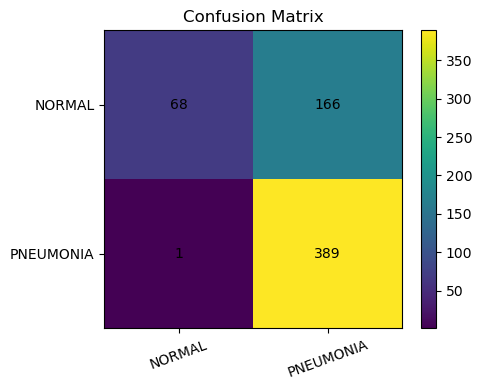

In [25]:
# Plot model performance with confusion matrix
plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xticks([0,1], classes, rotation=20)
plt.yticks([0,1], classes)
plt.colorbar()
for i in range(2):
  for j in range(2):
    plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

ROC-AUC: 0.908464825772518


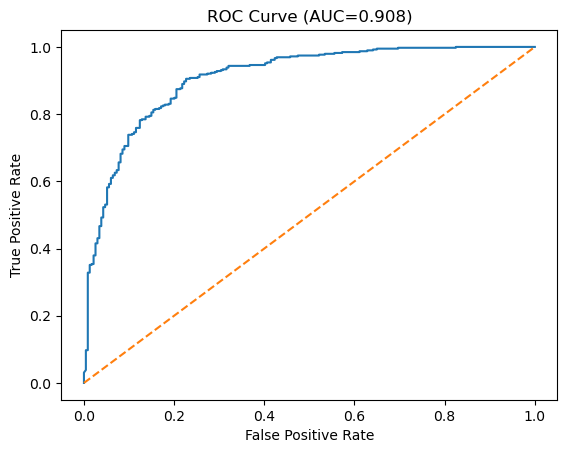

In [26]:
# AUC requires both classes present
if len(np.unique(y_true)) == 2:
  auc = roc_auc_score(y_true, y_prob_pos)
  fpr, tpr, thresholds = roc_curve(y_true, y_prob_pos)

  print("ROC-AUC:", auc)

  plt.figure()
  plt.plot(fpr, tpr)
  plt.plot([0,1], [0,1], linestyle="--")
  plt.title(f"ROC Curve (AUC={auc:.3f})")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.show()
else:
  print("ROC-AUC skipped: only one class present in y_true")

In [27]:
# Save results into this dataframe
results_df = pd.DataFrame({
    "true": y_true,
    "pred": y_pred,
    "prob_pneumonia": y_prob_pos
})

results_df["true_name"] = results_df["true"].apply(lambda i: classes[i])
results_df["pred_name"] = results_df["pred"].apply(lambda i: classes[i])
results_df["correct"] = results_df["true"] == results_df["pred"]

results_path = artifacts / "test_predictions.csv"
results_df.to_csv(results_path, index=False)
print("Saved:", results_path)

print("Accuracy:", results_df["correct"].mean())
print("Num errors:", (~results_df["correct"]).sum())

Saved: ..\artifacts\test_predictions.csv
Accuracy: 0.7323717948717948
Num errors: 167


In [28]:
# Look at wrong predictions
wrong = results_df[~results_df["correct"]].copy()
wrong = wrong.sort_values("prob_pneumonia", ascending=False)  # high pneu prob but wrong
wrong.head(10)

,true,pred,prob_pneumonia,true_name,pred_name,correct
144,0,1,0.999997,NORMAL,PNEUMONIA,False
121,0,1,0.999990,NORMAL,PNEUMONIA,False
133,0,1,0.999952,NORMAL,PNEUMONIA,False
130,0,1,0.999949,NORMAL,PNEUMONIA,False
136,0,1,0.999947,NORMAL,PNEUMONIA,False
123,0,1,0.999938,NORMAL,PNEUMONIA,False
140,0,1,0.999927,NORMAL,PNEUMONIA,False
129,0,1,0.999912,NORMAL,PNEUMONIA,False
193,0,1,0.999894,NORMAL,PNEUMONIA,False
134,0,1,0.999884,NORMAL,PNEUMONIA,False


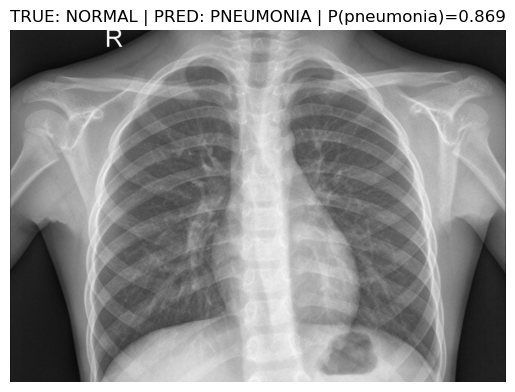

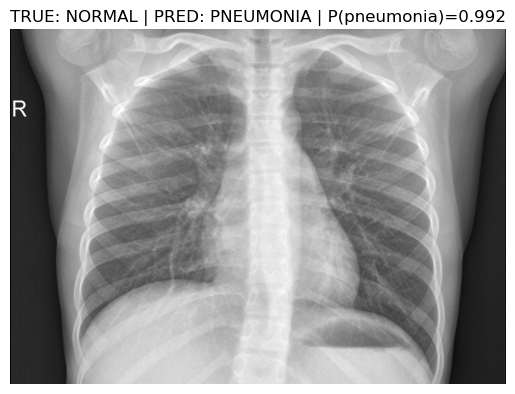

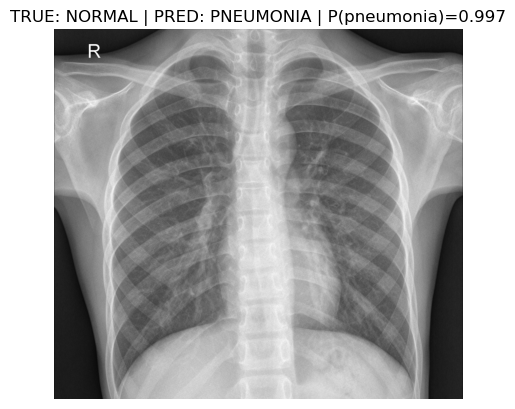

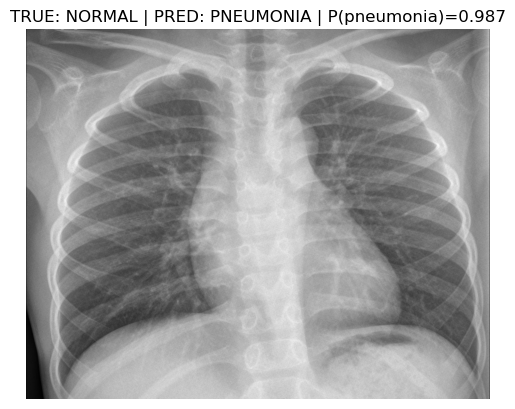

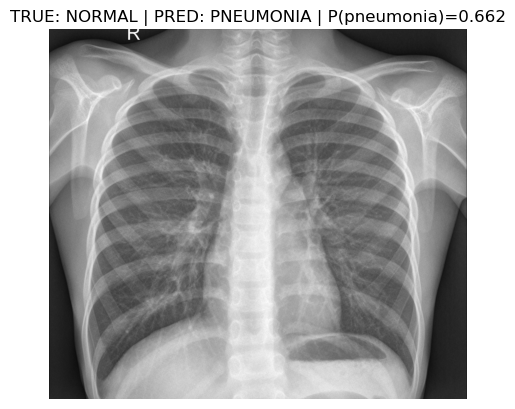

In [29]:
from PIL import Image

# Show mistaken images
def show_test_image(i):
    path, label = test_ds.samples[i]
    img = Image.open(path)
    plt.imshow(img, cmap="gray")
    plt.title(
        f"TRUE: {classes[y_true[i]]} | PRED: {classes[y_pred[i]]} | "
        f"P(pneumonia)={y_prob_pos[i]:.3f}"
    )
    plt.axis("off")
    plt.show()

# show first 5 mistakes
wrong_indices = np.where(y_true != y_pred)[0]
for idx in wrong_indices[:5]:
    show_test_image(idx)

In [30]:
np.random.seed(42)
torch.manual_seed(0)

# Define which class is positive
positive_class = "PNEUMONIA" if "PNEUMONIA" in classes else classes[1]
positive_index = classes.index(positive_class)
print("Positive class:", positive_class, "index:", positive_index)

# Copies weights and biases from dictionarty in model path
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

Positive class: PNEUMONIA index: 1


CXRNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [31]:
# Match training input
base_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # Converts image format of [H,W,C] tp [C,H,W] (channel height, weight)
])

In [32]:
from PIL import Image, ImageEnhance, ImageFilter
"""
Add blur, brightness, and gaussian noise to images
"""
def perturb_blur(img_pil, radius=1.0):
    return img_pil.filter(ImageFilter.GaussianBlur(radius=radius))

def perturb_brightness(img_pil, factor=1.1):
    # factor > 1 brighter, < 1 darker
    return ImageEnhance.Brightness(img_pil).enhance(factor)

def perturb_noise(img_pil, sigma=0.03):
    """
    Add Gaussian noise in [0,1] space
    sigma ~ 0.01 to 0.05 is mild
    """
    arr = np.array(img_pil).astype(np.float32) / 255.0
    noise = np.random.normal(0.0, sigma, size=arr.shape).astype(np.float32)
    arr_noisy = np.clip(arr + noise, 0.0, 1.0)
    return Image.fromarray((arr_noisy * 255).astype(np.uint8))

In [33]:
@torch.no_grad()
def predict_pos_prob(img_pil):
    """
    Returns:
      prob_pos: float probability of positive class
      pred_index: int predicted class index
    """
    # Unsqueeze(0) makes a batch of image format [1,C,H,W]
    x = base_transforms(img_pil).unsqueeze(0).to(DEVICE) # [1,1,224,224]
    logits = model(x) # [1,2]
    probs = torch.softmax(logits, dim=1)[0] # [2] -> Give probabilities from logits
    prob_pos = probs[positive_index].item()
    pred_index = int(torch.argmax(probs).item())
    return prob_pos, pred_index # probability, predicted class


In [34]:
def stability_metrics_for_image(img_pil, seed=0):
    """
    Generates multiple perturbations and measures how much the model's
    positive probability changes, and whether the predicted class flips.
    """
    rng = np.random.default_rng(seed)

    base_prob, base_pred = predict_pos_prob(img_pil)

    # Define a set of perturbations (mild but realistic)
    variants = []
    variants.append(("blur_1.0", perturb_blur(img_pil, radius=1.0)))
    variants.append(("blur_2.0", perturb_blur(img_pil, radius=2.0)))

    variants.append(("bright_0.9", perturb_brightness(img_pil, factor=0.9)))
    variants.append(("bright_1.1", perturb_brightness(img_pil, factor=1.1)))

    # noise: run twice with different randomness
    np.random.seed(seed)
    variants.append(("noise_0.02_a", perturb_noise(img_pil, sigma=0.02)))
    np.random.seed(seed + 1)
    variants.append(("noise_0.02_b", perturb_noise(img_pil, sigma=0.02)))

    probs = []
    preds = []
    for name, img2 in variants:
        p, pred = predict_pos_prob(img2)
        probs.append(p)
        preds.append(pred)

    probs = np.array(probs, dtype=np.float32)
    preds = np.array(preds, dtype=np.int64)

    # Metrics
    prob_std = float(probs.std()) # how much probability varies

    # big prob_range/mean_abs_delta -> confidence changes so not trustworthy
    prob_range = float(probs.max() - probs.min()) # max swing
    mean_abs_delta = float(np.mean(np.abs(probs - base_prob)))
    
    # fraction of perturbations that change predicted label
    # flip-rate = 0.0 -> prediction never changes so trustworthy
    # flip_rate > 0 -> some perturbations change predictions so not trustworthy
    flip_rate = float(np.mean(preds != base_pred))

    return {
        "base_prob_pos": float(base_prob),
        "base_pred_idx": int(base_pred),
        "prob_std": prob_std,
        "prob_range": prob_range,
        "mean_abs_delta": mean_abs_delta,
        "flip_rate": flip_rate
    }

In [35]:
# Load test dataset
test_ds = datasets.ImageFolder(test, transform=None)  # keep raw PIL images
print("Test samples:", len(test_ds))

# Each entry: (filepath, label_idx)
samples = test_ds.samples


Test samples: 624


In [36]:
# Check trustworthiness of 200 images
N = min(200, len(samples))
rows = []

for i in range(N):
    path, true_idx = samples[i]
    img = Image.open(path).convert("L") # images should be in grayscale PIL

    m = stability_metrics_for_image(img, seed=i)

    rows.append({
        "path": path,
        "true_idx": int(true_idx),
        "true_name": classes[int(true_idx)],
        **m,
        "base_pred_name": classes[m["base_pred_idx"]],
        "correct": (m["base_pred_idx"] == int(true_idx))
    })

df = pd.DataFrame(rows)
df.head()


,path,true_idx,true_name,base_prob_pos,base_pred_idx,prob_std,prob_range,mean_abs_delta,flip_rate,base_pred_name,correct
0,..\data\processed\cxr\test\NORMAL\IM-0001-0001...,0,NORMAL,0.868816,1,0.094183,0.293048,0.066716,0.000000,PNEUMONIA,False
1,..\data\processed\cxr\test\NORMAL\IM-0003-0001...,0,NORMAL,0.992291,1,0.000989,0.003020,0.000877,0.000000,PNEUMONIA,False
2,..\data\processed\cxr\test\NORMAL\IM-0005-0001...,0,NORMAL,0.997248,1,0.000304,0.001039,0.000215,0.000000,PNEUMONIA,False
3,..\data\processed\cxr\test\NORMAL\IM-0006-0001...,0,NORMAL,0.987453,1,0.002454,0.008200,0.001806,0.000000,PNEUMONIA,False
4,..\data\processed\cxr\test\NORMAL\IM-0007-0001...,0,NORMAL,0.661999,1,0.137042,0.449989,0.105480,0.166667,PNEUMONIA,False


In [ ]:
CONF_THRESH = 0.85
FLIP_THRESH = 0.10
DELTA_THRESH = 0.10

df["confident"] = df["base_prob_pos"].where(df["base_pred_idx"] == positive_index, 1 - df["base_prob_pos"]) > CONF_THRESH
df["trustworthy"] = (
    df["confident"] &
    (df["flip_rate"] <= FLIP_THRESH) &
    (df["mean_abs_delta"] <= DELTA_THRESH)
)

# 
print(df["trustworthy"].value_counts())
print(df.groupby("correct")["trustworthy"].mean())


trustworthy
True     163
False     37
Name: count, dtype: int64
correct
False    0.887324
True     0.637931
Name: trustworthy, dtype: float64


In [42]:
# out_path = artifacts / "trustworthiness_report_subset.csv"
# df.to_csv(out_path, index=False)
# print("Saved:", out_path)